In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [5]:
def format_snps(old_file, alt_col, new_file):
    old = pd.read_csv(old_file, sep='\t')
    s = old[alt_col].str.split(',').apply(Series, 1).stack()
    s.index = s.index.droplevel(-1)
    s.name = alt_col
    x = old.columns
    del old[alt_col]
    new = old.join(s)
    new = new[x]
    new.to_csv(new_file, sep='\t', index=False)

## Select Task

In [21]:
task='AD_CTRL_PARL'
snp_prefix="/mnt/lab_data2/annashch/alzheimers_parkinsons/dl_interpret/"
n_folds=10 
num_tasks=1 
all_snps_basename="chr17-only_dbsnp151_common_MAPT_HaplotypeRegion.txt"
ref_fasta="/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
model_prefix=model_dict[task]
idr_peaks=idr_dict[task]

## Get Predictions

In [22]:
for fold in [7]: 
    print(fold)
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":ambig_binary_crossentropy,
                    "ambig_mean_squared_error":ambig_mean_squared_error}
    model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
    print("loaded model")
    #get reference allele predictions 
    snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
    format_snps(snp_file, 'ALT', snp_file+'.corrected')
    new_snp_file = snp_file+'.corrected'
    snp_ref_generator=SNPGenerator(data_path=new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="REF")
    snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True,
                                                verbose=1)
    print("got snp ref predictions")
    #get alternate allele predictions 
    snp_alt_generator=SNPGenerator(new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="ALT")
    snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True, verbose=1)
    print("got snp alt predictions")

7
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 7s 59ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 6s 54ms/step
got snp alt predictions


## Save SNP Predictions

In [23]:
snp_ref_generator.data['ref_pred']=snp_ref_predictions
snp_ref_generator.data['alt_pred']=snp_alt_predictions
snp_ref_generator.data.to_csv(task+'.MAPT.SNP_predictions.txt',sep='\t')

## Load SNP Predictions

In [24]:
snp_predictions=pd.read_csv(task+'.MAPT.SNP_predictions.txt',header=0,sep='\t')
display(snp_predictions.head())
display(snp_predictions.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.060107,0.064034
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.050932,0.049251
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.090109,0.090109
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.090109,0.090109
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.093198,0.092361


(14506, 11)

## Calculate Number of SNPs in Peaks

In [25]:
old_snp_bed = pybedtools.BedTool(snp_file)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_old = old_snp_bed.intersect(idr_bed, u=True)
pos_snps_df_old = pybedtools.BedTool.to_dataframe(pos_snps_old)
pos_snps_df_old.columns = ['CHR', 'START', 'END', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
display(pos_snps_df_old.head())
display(pos_snps_df_old.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO
0,chr17,45487744,45487745,rs140167395,G,"C,T",.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...
1,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...
2,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...
3,chr17,45488233,45488234,rs62065444,T,C,.,.,RS=62065444;RSPOS=45488233;dbSNPBuildID=129;SS...
4,chr17,45490318,45490319,rs540797580,G,"A,C",.,.,RS=540797580;RSPOS=45490318;dbSNPBuildID=142;S...


(704, 9)

## Subset to SNPs in Peaks

In [26]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
pos_snps.columns = snp_predictions.columns
display(pos_snps.head())
display(pos_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45487744,45487745,rs140167395,G,C,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.256277,0.268590
1,chr17,45487744,45487745,rs140167395,G,T,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.256277,0.253566
2,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...,0.352121,0.352881
3,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...,0.341116,0.347172
4,chr17,45488233,45488234,rs62065444,T,C,.,.,RS=62065444;RSPOS=45488233;dbSNPBuildID=129;SS...,1.153134,1.126523


(814, 11)

## Plot Reference vs. Alternate Allele Predictions

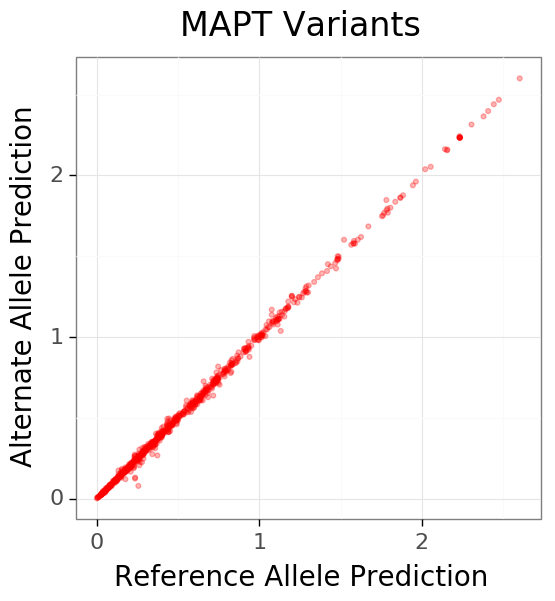

<ggplot: (-9223363282645701600)>

In [27]:
plotnine.options.figure_size = (6,6)
(ggplot(pos_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT Variants"))

## Calculate Difference between Reference and Alternate Prediction

In [28]:
pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [29]:
pos_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
758,chr17,46286843,46286844,rs2732614,C,T,.,.,RS=2732614;RSPOS=46286843;RV;dbSNPBuildID=100;...,0.254053,0.078803,-0.175250
96,chr17,45640555,45640556,rs189321003,C,G,.,.,RS=189321003;RSPOS=45640555;dbSNPBuildID=135;S...,0.233934,0.124398,-0.109536
95,chr17,45640555,45640556,rs189321003,C,A,.,.,RS=189321003;RSPOS=45640555;dbSNPBuildID=135;S...,0.233934,0.130074,-0.103860
498,chr17,45949183,45949184,rs565341342,G,T,.,.,RS=565341342;RSPOS=45949183;dbSNPBuildID=142;S...,0.371170,0.267382,-0.103789
191,chr17,45720412,45720413,rs149248693,A,G,.,.,RS=149248693;RSPOS=45720412;dbSNPBuildID=134;S...,1.131261,1.037695,-0.093566
183,chr17,45719865,45719866,rs118010751,G,A,.,.,RS=118010751;RSPOS=45719865;dbSNPBuildID=132;S...,0.715388,0.637574,-0.077814
602,chr17,46044477,46044478,rs147482271,T,G,.,.,RS=147482271;RSPOS=46044477;dbSNPBuildID=134;S...,0.339825,0.275212,-0.064613
401,chr17,45894419,45894420,rs11575895,A,G,.,.,RS=11575895;RSPOS=45894419;dbSNPBuildID=120;SS...,0.938837,0.876984,-0.061853
143,chr17,45688986,45688987,rs17688205,G,A,.,.,RS=17688205;RSPOS=45688986;dbSNPBuildID=123;SS...,0.682821,0.627489,-0.055332
793,chr17,46759352,46759353,rs140197220,G,C,.,.,RS=140197220;RSPOS=46759352;dbSNPBuildID=134;S...,0.174147,0.120327,-0.053819


## Get Alternate SNPs with most positive effect

In [30]:
pos_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
14,chr17,45490912,45490913,rs371185851,T,TGA,.,.,RS=371185851;RSPOS=45490912;dbSNPBuildID=138;S...,1.199538,1.254494,0.054957
15,chr17,45490912,45490913,rs371185851,T,TGAG,.,.,RS=371185851;RSPOS=45490912;dbSNPBuildID=138;S...,1.199538,1.254494,0.054957
70,chr17,45586357,45586358,rs532604338,G,C,.,.,RS=532604338;RSPOS=45586357;dbSNPBuildID=142;S...,0.551703,0.606761,0.055058
227,chr17,45741793,45741794,rs544516523,T,C,.,.,RS=544516523;RSPOS=45741793;dbSNPBuildID=142;S...,0.432166,0.493349,0.061183
169,chr17,45706004,45706005,rs6503444,T,C,.,.,RS=6503444;RSPOS=45706004;dbSNPBuildID=116;SSR...,1.075632,1.137396,0.061764
47,chr17,45585365,45585366,rs112069536,G,C,.,.,RS=112069536;RSPOS=45585365;dbSNPBuildID=132;S...,1.781779,1.847599,0.065821
468,chr17,45909054,45909055,rs4371195,A,G,.,.,RS=4371195;RSPOS=45909054;dbSNPBuildID=111;SSR...,0.656249,0.725741,0.069492
184,chr17,45719880,45719881,rs56046792,C,T,.,.,RS=56046792;RSPOS=45719880;dbSNPBuildID=129;SS...,0.745679,0.817198,0.071518
48,chr17,45585367,45585368,rs114316249,C,T,.,.,RS=114316249;RSPOS=45585367;dbSNPBuildID=132;S...,1.521083,1.601975,0.080892
170,chr17,45706004,45706005,rs6503444,T,G,.,.,RS=6503444;RSPOS=45706004;dbSNPBuildID=116;SSR...,1.075632,1.169041,0.093409


## Subset to SNPs NOT in Peaks

In [31]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
neg_snps.columns = snp_predictions.columns
display(neg_snps.head())
display(neg_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.060107,0.064034
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.050932,0.049251
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.090109,0.090109
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.090109,0.090109
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.093198,0.092361


(13692, 11)

## Plot Reference vs. Alternate Allele Predictions

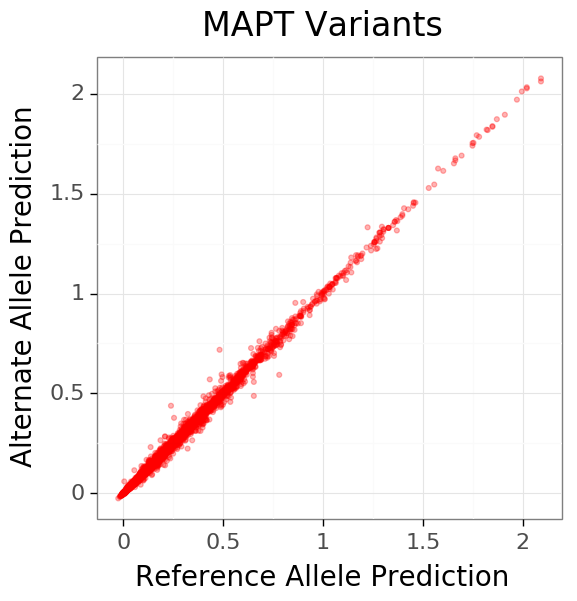

<ggplot: (-9223363282645624965)>

In [32]:
plotnine.options.figure_size = (6,6)
(ggplot(neg_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT Variants"))

## Calculate Difference between Reference and Alternate Prediction

In [33]:
neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [34]:
neg_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
460,chr17,45501558,45501559,rs149575984,G,A,.,.,RS=149575984;RSPOS=45501558;dbSNPBuildID=134;S...,0.780614,0.593041,-0.187573
3402,chr17,45748125,45748126,rs8064404,G,A,.,.,RS=8064404;RSPOS=45748125;dbSNPBuildID=116;SSR...,0.653433,0.487778,-0.165654
3053,chr17,45722444,45722445,rs76667867,G,C,.,.,RS=76667867;RSPOS=45722444;dbSNPBuildID=132;SS...,0.321743,0.223898,-0.097845
3403,chr17,45748125,45748126,rs8064404,G,T,.,.,RS=8064404;RSPOS=45748125;dbSNPBuildID=116;SSR...,0.653433,0.557703,-0.095730
5336,chr17,45862428,45862429,rs148132688,C,T,.,.,RS=148132688;RSPOS=45862428;dbSNPBuildID=134;S...,0.344547,0.265734,-0.078813
3401,chr17,45748112,45748113,rs75715199,G,A,.,.,RS=75715199;RSPOS=45748112;dbSNPBuildID=132;SS...,0.535658,0.457746,-0.077912
2407,chr17,45679544,45679545,rs62055693,T,C,.,.,RS=62055693;RSPOS=45679544;dbSNPBuildID=129;SS...,0.386165,0.312321,-0.073844
3276,chr17,45736978,45736979,rs143317719,C,A,.,.,RS=143317719;RSPOS=45736978;dbSNPBuildID=134;S...,0.208848,0.140477,-0.068371
5380,chr17,45864940,45864941,rs544132309,G,A,.,.,RS=544132309;RSPOS=45864940;dbSNPBuildID=142;S...,0.396696,0.329282,-0.067414
459,chr17,45501545,45501546,rs190583615,C,T,.,.,RS=190583615;RSPOS=45501545;dbSNPBuildID=135;S...,0.754723,0.687909,-0.066814


## Get Alternate SNPs with most positive effect

In [35]:
neg_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
2210,chr17,45665337,45665338,rs189478344,G,A,.,.,RS=189478344;RSPOS=45665337;dbSNPBuildID=135;S...,0.496547,0.581923,0.085376
5276,chr17,45861334,45861335,rs553405997,C,T,.,.,RS=553405997;RSPOS=45861334;dbSNPBuildID=142;S...,0.639484,0.726979,0.087495
666,chr17,45520224,45520225,rs115881608,A,T,.,.,RS=115881608;RSPOS=45520224;dbSNPBuildID=132;S...,0.861260,0.953133,0.091873
6360,chr17,45928124,45928125,rs116170020,T,C,.,.,RS=116170020;RSPOS=45928124;dbSNPBuildID=132;S...,0.136201,0.231653,0.095452
3360,chr17,45744361,45744362,rs541383561,C,T,.,.,RS=541383561;RSPOS=45744361;dbSNPBuildID=142;S...,0.491895,0.595214,0.103319
5903,chr17,45897919,45897920,rs62056786,T,C,.,.,RS=62056786;RSPOS=45897919;dbSNPBuildID=129;SS...,1.223657,1.331201,0.107544
1451,chr17,45601778,45601779,rs537001098,C,T,.,.,RS=537001098;RSPOS=45601778;dbSNPBuildID=142;S...,0.253518,0.377904,0.124387
13272,chr17,46743059,46743060,rs199536,T,A,.,.,RS=199536;RSPOS=46743059;dbSNPBuildID=79;SSR=0...,0.432590,0.570420,0.137830
3222,chr17,45733507,45733508,rs75022332,A,T,.,.,RS=75022332;RSPOS=45733507;dbSNPBuildID=131;SS...,0.238136,0.438516,0.200380
2416,chr17,45679828,45679829,rs144766143,G,A,.,.,RS=144766143;RSPOS=45679828;dbSNPBuildID=134;S...,0.481768,0.718456,0.236687
